In [1]:
import pandas as pd
from datetime import datetime
from zoe import cases, query, pickle, find_previous, plot_study, plot_study_evolution

In [2]:
uk_active_cases = query("SELECT * FROM uk_active_cases", index='date')
uk_active_cases.index = pd.to_datetime(uk_active_cases.index, format='%Y%m%d')
uk_active_cases

,cartodb_id,the_geom,the_geom_webmercator,corrected_covid_positive
date,,,,
2020-06-12,64972,None,None,86085.715275
2020-06-13,64973,None,None,79940.811469
2020-06-14,64974,None,None,74244.112992
2020-06-15,64975,None,None,68878.187593
2020-06-16,64976,None,None,64137.552455
...,...,...,...,...
2021-06-02,65327,None,None,68107.416422
2021-06-03,65328,None,None,73196.498916
2021-06-04,65329,None,None,78890.803314


In [3]:
curr_date = uk_active_cases.index.max()
print(pickle(uk_active_cases, 'uk_active_cases', curr_date))

/Users/chris/coronavirus/data/zoe_uk_active_cases_2021-06-06_2021-06-06-18-36.pickle


In [4]:
prev_date, prev_uk_active_cases = find_previous(curr_date)

/Users/chris/coronavirus/data/zoe_uk_active_cases_2021-06-05_2021-06-05-16-58.pickle


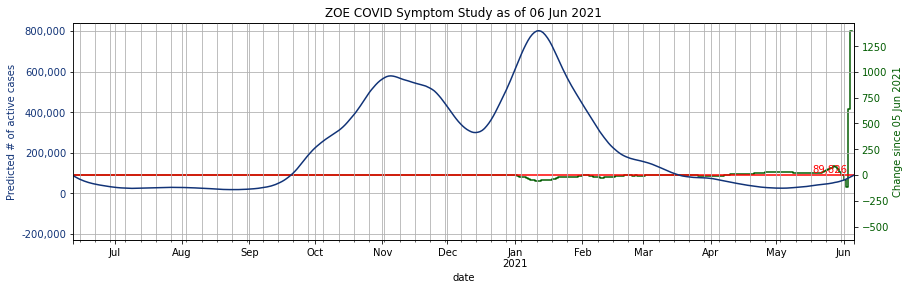

In [5]:
plot_study(curr_date, prev_date, uk_active_cases, prev_uk_active_cases)

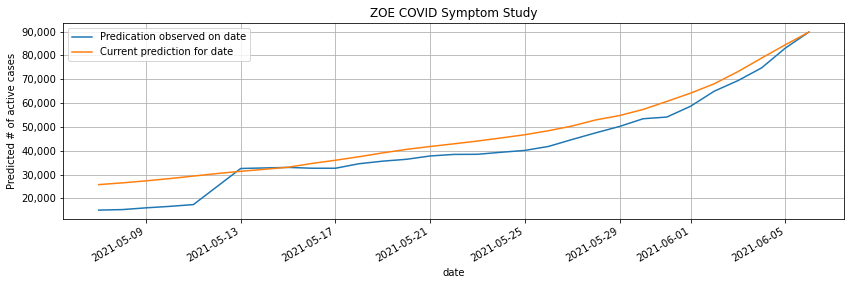

In [6]:
plot_study_evolution(curr_date, days=30)

In [7]:
prevalence_map = query("SELECT * FROM prevalence_map")
prevalence_map['percentage'] = prevalence_map['percentage'].astype(float)

In [8]:
for_date, = prevalence_map['data_status'].unique()
print(pickle(prevalence_map, 'prevalence_map', datetime.strptime(for_date, '%H:%M:%S %d-%m-%Y')))

/Users/chris/coronavirus/data/zoe_prevalence_map_2021-06-06_2021-06-06-18-37.pickle


In [9]:
prevalence_map[['lad16nm', 'lad16cd', 'percentage']].sort_values('percentage', ascending=False)[:10]

,lad16nm,lad16cd,percentage
29,Nottingham,E06000018,1.893356
272,Tameside,E08000008,1.637258
267,Bury,E08000002,0.858400
174,Preston,E07000123,0.828907
286,Sunderland,E08000024,0.600058
273,Trafford,E08000009,0.598435
274,Wigan,E08000010,0.589196
308,Perth and Kinross,S12000024,0.582428
233,Manchester,E08000003,0.581415
316,City of Edinburgh,S12000036,0.537763
